In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
batch_size=16

In [4]:
#training data
traindata=torchvision.datasets.CIFAR10(root="/content/",train=True,download=True,transform=transform)
train=DataLoader(traindata,batch_size=batch_size,shuffle=True)
#testing data
testdata=torchvision.datasets.CIFAR10(root="/content/",train=False,download=True,transform=transform)
test=DataLoader(testdata,batch_size=batch_size,shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 59156279.49it/s]


Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
next(iter(train))

[tensor([[[[ 0.0902,  0.1373,  0.1373,  ...,  0.9843,  0.9843,  0.9843],
           [ 0.0824,  0.0980,  0.1059,  ...,  1.0000,  1.0000,  1.0000],
           [ 0.0353,  0.0353,  0.0510,  ...,  0.9922,  0.9922,  0.9922],
           ...,
           [ 0.6863,  0.7569,  0.7961,  ...,  0.0431,  0.0275,  0.0353],
           [ 0.7412,  0.7255,  0.8039,  ...,  0.0431,  0.0431,  0.0431],
           [ 0.7569,  0.6941,  0.7882,  ...,  0.0353,  0.0353,  0.0275]],
 
          [[ 0.4510,  0.4980,  0.5059,  ...,  0.9843,  0.9843,  0.9843],
           [ 0.4667,  0.4745,  0.4902,  ...,  1.0000,  1.0000,  1.0000],
           [ 0.4353,  0.4353,  0.4431,  ...,  0.9922,  0.9922,  0.9922],
           ...,
           [ 0.8353,  0.8510,  0.8745,  ...,  0.4275,  0.4275,  0.4118],
           [ 0.8667,  0.8510,  0.8980,  ...,  0.4431,  0.4353,  0.4275],
           [ 0.8588,  0.8275,  0.8824,  ...,  0.4275,  0.4275,  0.4118]],
 
          [[ 0.7725,  0.8039,  0.8196,  ...,  0.9843,  0.9843,  0.9843],
           [ 

In [7]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

In [8]:
dataiter=iter(train)
images,labels=(next(dataiter))

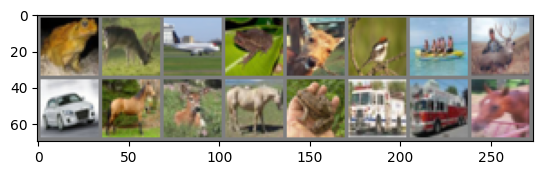

frog  deer  plane frog  deer  bird  ship  deer  car   horse deer  horse frog  truck truck horse


In [9]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
class CIFARnet(nn.Module):
  def __init__(self):
    super(CIFARnet, self).__init__()
    self.block1 = nn.Sequential(
            nn.Conv2d(3,32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
          )
    self.block2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12544, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128,10),
            nn.BatchNorm1d(10)
          )
  def forward(self, x):
      x = self.block1(x)
      return self.block2(x)

In [11]:
device=("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [12]:
model=CIFARnet()
model.to(device)

CIFARnet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=10, bias=True)
    (6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [13]:
learning_rate=0.001
num_epochs=10

In [14]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=learning_rate)

In [15]:
# Lists to store loss values
train_losses = []
test_losses = []

In [16]:
from sklearn.metrics import accuracy_score

def train_model(model, dataloader, optmizer, loss_fn):
    model.train()
    train_loss, train_acc= 0, 0

    for X, y in dataloader:
        # Forward Pass
        X, y = X.to(torch.device("cuda")), y.to(torch.device("cuda"))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

        # Back Propagation
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        train_loss /= len(dataloader)
        train_losses.append(train_loss.item())

    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")
    return train_losses

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
def test_model(model, dataloader, optmizer, loss_fn):
    model.eval()
    val_loss, val_acc= 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            val_loss += loss_fn(y_pred, y)
            val_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

            val_loss /= len(dataloader)
            test_losses.append(val_loss.item())
        val_acc /= len(dataloader)
        print(f"test loss: {val_loss:.4f}     | test accuracy: {val_acc:.4f}")
    return test_losses

epoch: 0
--------------------------------------------------------
Train loss: 0.0005 | Train accuracy: 0.4853
test loss: 0.0011     | test accuracy: 0.6370
epoch: 1
--------------------------------------------------------
Train loss: 0.0003 | Train accuracy: 0.5721
test loss: 0.0014     | test accuracy: 0.6805
epoch: 2
--------------------------------------------------------
Train loss: 0.0004 | Train accuracy: 0.6048
test loss: 0.0010     | test accuracy: 0.6932
epoch: 3
--------------------------------------------------------
Train loss: 0.0003 | Train accuracy: 0.6301
test loss: 0.0012     | test accuracy: 0.7064
epoch: 4
--------------------------------------------------------
Train loss: 0.0005 | Train accuracy: 0.6504
test loss: 0.0016     | test accuracy: 0.7092
epoch: 5
--------------------------------------------------------
Train loss: 0.0002 | Train accuracy: 0.6662
test loss: 0.0012     | test accuracy: 0.7268
epoch: 6
-------------------------------------------------------

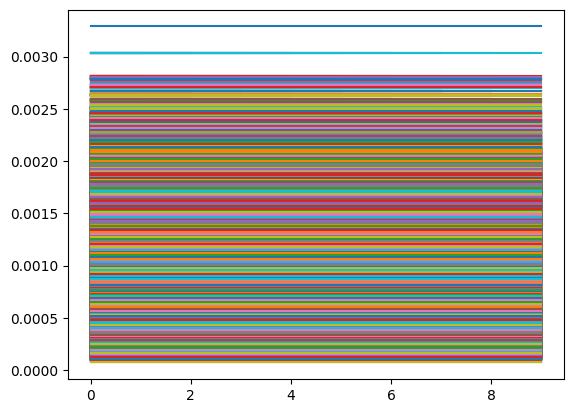

In [18]:
tloss=[]
vloss=[]
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    print("--------------------------------------------------------")
    tloss.append(train_model(model, train, optimizer, loss_fn))
    vloss.append(test_model(model, test, optimizer, loss_fn))
    #test_loop(model,test_data,optimizer,loss_fn)

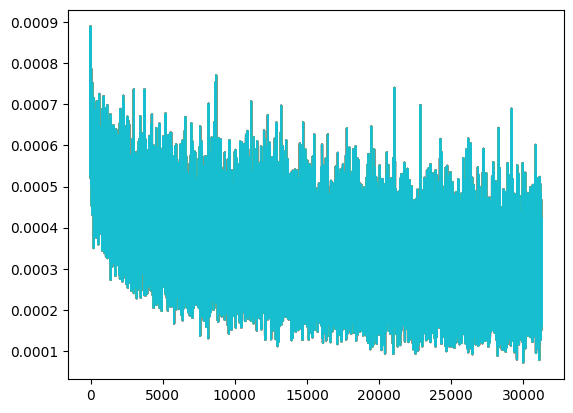

In [22]:
for i in range(len(tloss)):
    plt.plot(tloss[i],label="Training loss")

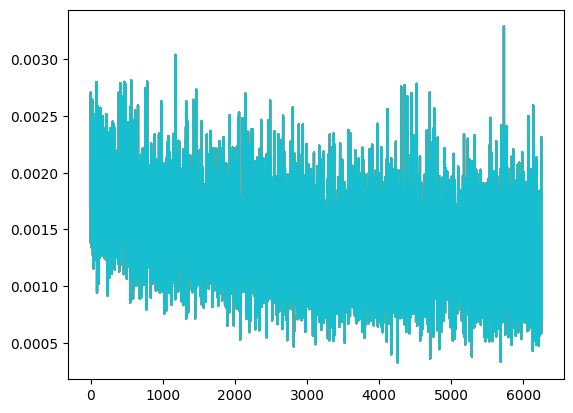

In [23]:
for j in range(len(vloss)):
    plt.plot(vloss[i],label="testing loss")